<a href="https://colab.research.google.com/github/Apurba03/Skinlesion/blob/main/Skinlesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import os
import zipfile
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json file
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!mkdir -p data/HAM10000
!unzip -q skin-cancer-mnist-ham10000.zip -d data/HAM10000
print("Dataset downloaded and extracted successfully.")

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:53<00:00, 36.2MB/s]
100% 5.20G/5.20G [01:53<00:00, 49.2MB/s]
Dataset downloaded and extracted successfully.


In [3]:
def load_and_prepare_metadata(metadata_path):
    #Loads metadata from a CSV file and encodes skin lesion diagnosis into numeric labels.
    df = pd.read_csv(metadata_path)
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['dx'])
    print(df.head())
    print("Number of rows in metadata:", len(df))
    print(f"Label classes: {list(le.classes_)}")
    return df, le
# Execute metadata loading:
metadata_path = "data/HAM10000/HAM10000_metadata.csv"
df, label_encoder = load_and_prepare_metadata(metadata_path)


     lesion_id      image_id   dx dx_type   age   sex localization  label
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp      2
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp      2
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp      2
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp      2
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear      2
Number of rows in metadata: 10015
Label classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [4]:
!find data/HAM10000 -type f -name "*.jpg" | head -n 5

data/HAM10000/HAM10000_images_part_2/ISIC_0031357.jpg
data/HAM10000/HAM10000_images_part_2/ISIC_0033226.jpg
data/HAM10000/HAM10000_images_part_2/ISIC_0030605.jpg
data/HAM10000/HAM10000_images_part_2/ISIC_0029943.jpg
data/HAM10000/HAM10000_images_part_2/ISIC_0033303.jpg


In [5]:
def load_images(df, img_dir, size=224):
    image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(img_dir, '*', '*.jpg'))}
    print(f"Found {len(image_paths)} images.")
    df['path'] = df['image_id'].map(image_paths.get)
    df['image'] = df['path'].map(lambda x: img_to_array(Image.open(x).resize((size, size))) if x else None)
    df = df[df['image'].notnull()]
    print(f"Dataframe now has {len(df)} samples after loading images.")
    return df
# Run the image loading step again:
# Take a sample of 5000 images before loading
df_sampled = df.sample(n=4000, random_state=42).reset_index(drop=True)
df = load_images(df_sampled, "data/HAM10000", size=224)

Found 10015 images.
Dataframe now has 4000 samples after loading images.


In [6]:
!ls -l data/HAM10000

total 130808
drwxr-xr-x 2 root root   167936 May 18 17:52 ham10000_images_part_1
drwxr-xr-x 2 root root   167936 May 18 17:51 HAM10000_images_part_1
drwxr-xr-x 2 root root   172032 May 18 17:52 ham10000_images_part_2
drwxr-xr-x 2 root root   172032 May 18 17:51 HAM10000_images_part_2
-rw-r--r-- 1 root root   563277 Oct  6  2019 HAM10000_metadata.csv
-rw-r--r-- 1 root root 30807979 Oct  6  2019 hmnist_28_28_L.csv
-rw-r--r-- 1 root root 91820383 Oct  6  2019 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root  2537778 Oct  6  2019 hmnist_8_8_L.csv
-rw-r--r-- 1 root root  7524968 Oct  6  2019 hmnist_8_8_RGB.csv


In [7]:
def prepare_and_balance_data(df, num_classes, samples_per_class=550):
    # Split dataset BEFORE balancing to preserve test distribution.Then, balance the training set by up-sampling each class to the desired number of samples.
    train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)
    # Balance only the training set.The test set remains unbalanced.
    train_balanced = pd.concat([
        resample(train_df[train_df['label'] == i],
                 replace=True,
                 n_samples=samples_per_class,
                 random_state=42)
        for i in train_df['label'].unique()
    ])
    print("Training set label distribution after balancing:")
    print(train_balanced['label'].value_counts())
    return train_balanced, test_df
# Split and balance:
num_classes = 7
train_df, test_df = prepare_and_balance_data(df, num_classes=num_classes, samples_per_class=550)


Training set label distribution after balancing:
label
5    550
4    550
1    550
2    550
0    550
6    550
3    550
Name: count, dtype: int64


In [8]:
def dataframes_to_arrays(train_df, test_df, num_classes):
    """
    Convert the train and test dataframes containing images and labels into numpy arrays.
    Normalize image pixel values and returns x_train, x_test, y_train, y_test.
    """
    x_train = np.array(train_df['image'].tolist(), dtype='float32') / 255.0
    x_test = np.array(test_df['image'].tolist(), dtype='float32') / 255.0
    y_train = to_categorical(train_df['label'], num_classes=num_classes)
    y_test = to_categorical(test_df['label'], num_classes=num_classes)
    return x_train, x_test, y_train, y_test
# Convert data:
x_train, x_test, y_train, y_test = dataframes_to_arrays(train_df, test_df, num_classes=num_classes)


In [9]:
def build_mobilenet_model(input_shape=(224, 224, 3), num_classes=7, dropout_rate=0.5, l2_reg=1e-4):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = build_mobilenet_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()

<ipython-input-9-00954cb7b68e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,427,975 (9.26 MB)

 Trainable params: 167,431 (654.03 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [11]:
def train_model(model, x_train, y_train, x_val, y_val, batch_size=16, epochs=10):
    """
    Trains the model using the training data and validates it on the validation set.
    """
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, epochs=epochs, verbose=2)
    return history
# Train model:
history = train_model(model, x_train, y_train, x_test, y_test, batch_size=16, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


241/241 - 33s - 137ms/step - accuracy: 0.3231 - loss: 2.1002 - val_accuracy: 0.4690 - val_loss: 1.4934
Epoch 2/10
241/241 - 5s - 22ms/step - accuracy: 0.5262 - loss: 1.3800 - val_accuracy: 0.5340 - val_loss: 1.3516
Epoch 3/10
241/241 - 11s - 44ms/step - accuracy: 0.6273 - loss: 1.1066 - val_accuracy: 0.5500 - val_loss: 1.2893
Epoch 4/10
241/241 - 10s - 42ms/step - accuracy: 0.6719 - loss: 0.9448 - val_accuracy: 0.5660 - val_loss: 1.2418
Epoch 5/10
241/241 - 5s - 21ms/step - accuracy: 0.7187 - loss: 0.8297 - val_accuracy: 0.5680 - val_loss: 1.2389
Epoch 6/10
241/241 - 5s - 22ms/step - accuracy: 0.7478 - loss: 0.7582 - val_accuracy: 0.5790 - val_loss: 1.2025
Epoch 7/10
241/241 - 5s - 22ms/step - accuracy: 0.7714 - loss: 0.6936 - val_accuracy: 0.5880 - val_loss: 1.1661
Epoch 8/10
241/241 - 10s - 43ms/step - accuracy: 0.7932 - loss: 0.6192 - val_accuracy: 0.5980 - val_loss: 1.1411
Epoch 9/10
241/241 - 5s - 22ms/step - accuracy: 0.8164 - loss: 0.5837 - val_accuracy: 0.5960 - val_loss: 1.153


Test accuracy: 0.6020


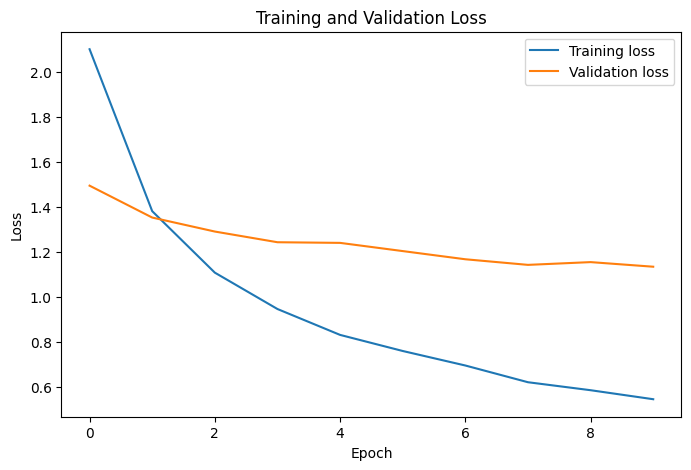

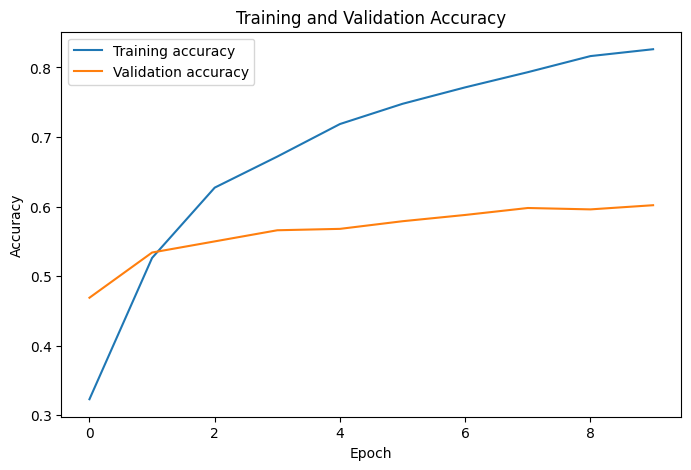

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step


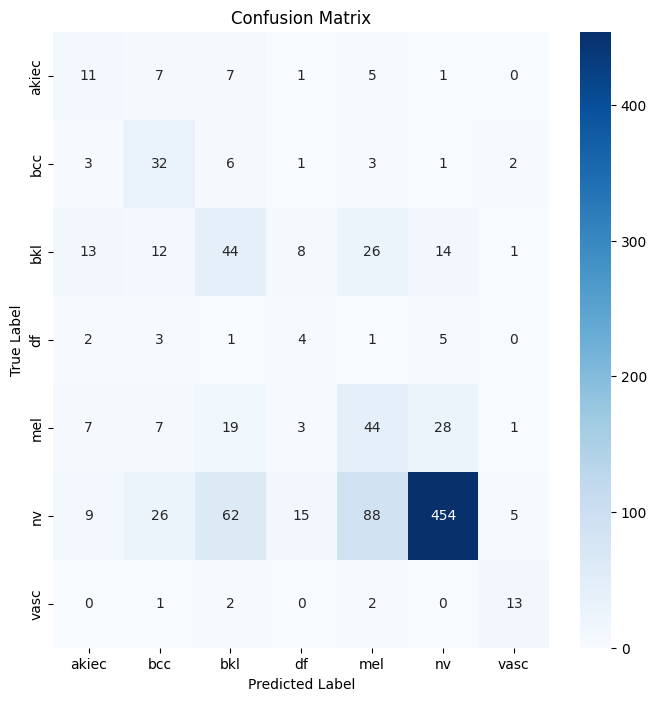

In [12]:
def evaluate_model(model, history, x_test, y_test, class_names):
    """
    Evaluates the model on the test set and creates plots for loss, accuracy,
    and a confusion matrix.
    """
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest accuracy: {score[1]:.4f}")

    # Plot training/validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training/validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Confusion Matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Evaluate model:
evaluate_model(model, history, x_test, y_test, label_encoder.classes_)


Saving ISIC_0024306.jpg to ISIC_0024306 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


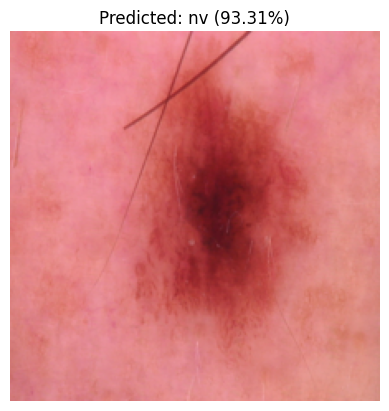

In [13]:
def classify_image(model, image_path, label_encoder, img_size=224):
    """
    Loads an image from the given path, preprocesses it, and predicts the class using the trained model.
    """
    try:
        img = Image.open(image_path).resize((img_size, img_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        confidence = prediction[0][predicted_class]

        class_name = label_encoder.inverse_transform([predicted_class])[0]

        # Display image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_name} ({confidence*100:.2f}%)")
        plt.show()

        return class_name, confidence
    except Exception as e:
        print("Error loading image:", e)
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded image filename

# Predict and show result
predicted_class, confidence = classify_image(model, image_path, label_encoder)
